In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Release Frequency

## Default HyRAM system:

#### Imports

In [5]:
from hyram_qra import Component, Components, Event, Events, System, Tree, LogNorm, Beta, ExpectedValue, Leak, Leaks

#### Data from matlab and/or HyRAM

In [6]:
import scipy.io as spio

LeakFreqData = spio.loadmat('C:\Users\ehecht\Documents\H2 Codes and Standards\HyRAM\Legacy\matlab_source\LeakFreqData.mat', squeeze_me=True)
ComponentFailureData = spio.loadmat('C:\Users\ehecht\Documents\H2 Codes and Standards\HyRAM\Legacy\matlab_source\ComponentFailureData.mat', squeeze_me=True)

In [7]:
nvehicles = 20; nfuelingspervehicleday = 2; nvehicleoperatingdays = 250

#### objects used to build the system

In [8]:
## components from matlab matrix probability data:
components = Components()
for component in LeakFreqData['Component']:
    comp = Component(component[0])
    for size, mu, sigma in zip([.01, .1, 1, 10, 100], component[1], component[2]):
        comp.leak += Leak('spontaneous', size, LogNorm(sigma, mu))
    components += comp
    
## Events from matlab matrix probabilities
events = Events()
for k in ComponentFailureData.keys():
    if k[0] != '_' and k != 'Qt' and k != 'betafactor3':
        if ComponentFailureData[k].dtype.fields.has_key('alpha'):
            events += Event(k, Beta(*ComponentFailureData[k].tolist()))
        if ComponentFailureData[k].dtype.fields.has_key('mean'):
            events += Event(k, ExpectedValue(*ComponentFailureData[k].tolist()))
        if ComponentFailureData[k].dtype.fields.has_key('sigma'):
            events += Event(k, LogNorm(*ComponentFailureData[k].tolist()))

#### put together the system

In [9]:
indoor_station = System()

indoor_station.add_components(components.Hoses, 1)
indoor_station.add_components(components.Joints, 35)
indoor_station.add_components(components.Pipes, 20)
indoor_station.add_components(components.Valves, 5)
indoor_station.add_components(components.Instruments, 3)

## accidents from ReleaseFreq.m
indoor_station.accidents = Events('accidents')
indoor_station.accidents += events.Driveoff.AND(events.BC_FTC, None, 'driveoff leak', False, leak_size = 100)
indoor_station.accidents += events.OPduringfueling.AND(events.PRV_FTO, None,  
                                                       'overpressure induced rupture', False, leak_size = 100)

## shutdown failures
indoor_station.shutdown_fail = Events('shutdown failures')
solenoid_valve_fail = events.ASV_FTC.AND(events.ASV_FTC.AND(events.ASV_FTC)
                                        ).OR(events.ASV_CCF3, 'ASV_FTC_X3', 'all solenoid valves fail to close', False)
release_pathway = events.Nozzle_popoff.OR(events.Nozzle_FTC, 'nozzle_leaks', 'nozzle leaks', False)
events.HV_FTC.description = 'relief valve open'
indoor_station.shutdown_fail += solenoid_valve_fail.AND(release_pathway).AND(events.HV_FTC, leak_size = 100)

indoor_station.accidents.OPduringfueling_AND_PRV_FTO.number = nvehicles*nfuelingspervehicleday*nvehicleoperatingdays
indoor_station.accidents.Driveoff_AND_BC_FTC.number = nvehicles*nfuelingspervehicleday*nvehicleoperatingdays
indoor_station.shutdown_fail.ASV_FTC_X3_AND_nozzle_leaks_AND_HV_FTC.number = nvehicles*nfuelingspervehicleday*nvehicleoperatingdays
                                                                     
indoor_station

<hyram_qra._System.System instance at 0x000000000B3D9788>

### Frequency of releases:

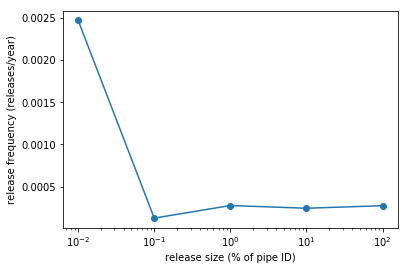

In [13]:
sizes = np.logspace(-2, 2, 5)
semilogx(sizes, map(lambda k: indoor_station.release_frequency()[k], sizes), '-o');
ylabel('release frequency (releases/year)'); xlabel('release size (% of pipe ID)');

Seems somewhat reasonable, except for the 0.1% leak rate, pretty sure this is due to the joints -- see below.  Throwing out that data points, most releases are small (0.01%) and then the probability decreases until you get to the 100% release.  Since there are other events that can lead to the 100% release, there is a slight bump up for this size.

## component frequency distributions

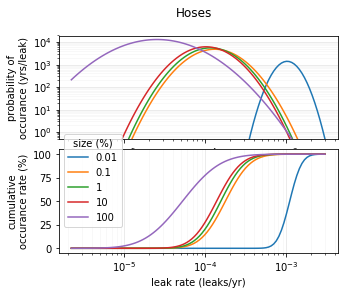

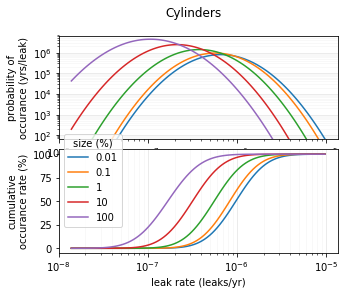

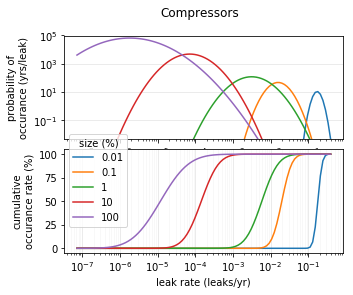

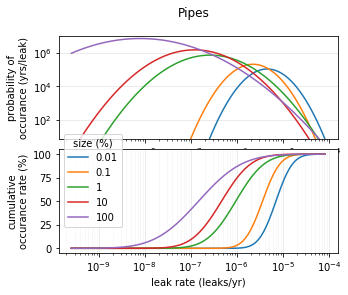

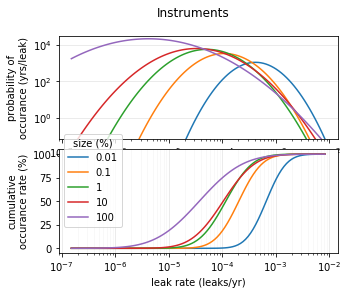

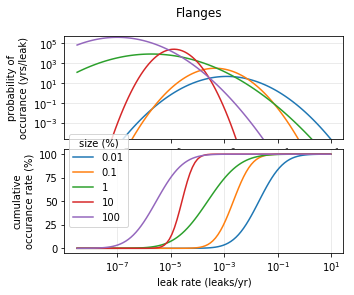

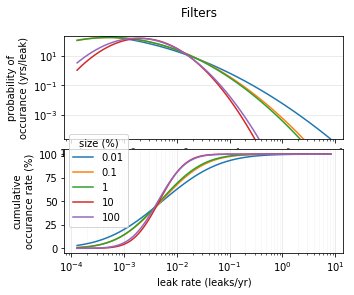

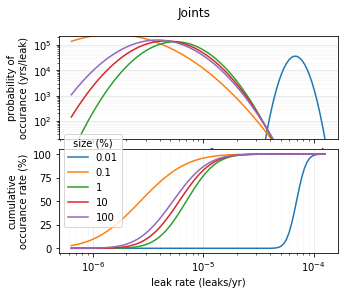

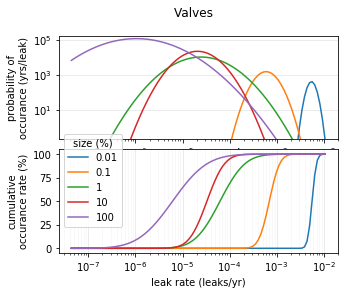

In [11]:
for k in components.__dict__.keys():
    if isinstance(components.__dict__[k], Component):
        components.__dict__[k].leak.plot()
        plt.suptitle(components.__dict__[k].type)

Data needs to be checked - why is .1% release for joints least probable? followed by 100, 10, 1, .01.  Seems like something is off.

# Probit models

In [8]:
from hyram_qra import Fatality

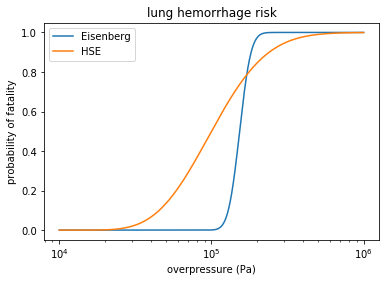

In [33]:
semilogx(np.linspace(10000, 1e6, 1000), Fatality.lung_Eisenberg(np.linspace(1, 1e6, 1000)), label = 'Eisenberg');
plot(np.linspace(10000, 1e6, 1000), Fatality.lung_HSE(np.linspace(.1, 1e6, 1000)), label = 'HSE');
legend();
ylabel('probability of fatality'); xlabel('overpressure (Pa)'); title('lung hemorrhage risk');

In [34]:
thermal_dose = lambda heat_flux, exposure_time: heat_flux**(4./3)*exposure_time

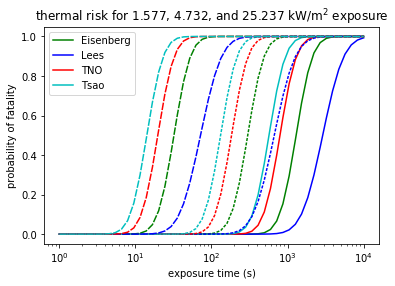

In [57]:
t = logspace(0, 4)
fluxes = np.array([1.577, 4.732, 25.237])*1e3
dashes = {1577: (5,5), 4732: (2,1), 25237: (5, 1)}
colors = ['g', 'b', 'r', 'c']
flux = fluxes[0]
semilogx(t, Fatality.thermal_Eisenberg(flux, t), c = colors[0], label = 'Eisenberg');
semilogx(t, Fatality.thermal_Lees(flux, t), c = colors[1], label = 'Lees');
semilogx(t, Fatality.thermal_TNO(flux, t), c = colors[2], label = 'TNO');
semilogx(t, Fatality.thermal_Tsao(flux, t), c = colors[3], label = 'Tsao');
for flux in fluxes[1:]:
    semilogx(t, Fatality.thermal_Eisenberg(flux, t), dashes = dashes[flux], c = colors[0]);
    semilogx(t, Fatality.thermal_Lees(flux, t), dashes = dashes[flux], c = colors[1]);
    semilogx(t, Fatality.thermal_TNO(flux, t), dashes = dashes[flux], c = colors[2]);
    semilogx(t, Fatality.thermal_Tsao(flux, t), dashes = dashes[flux], c = colors[3]);
legend();
ylabel('probability of fatality'); xlabel('exposure time (s)'); 
title('thermal risk for 1.577, 4.732, and 25.237 kW/m$^2$ exposure');

# What's left?


generate positions, create the flames and calculate the heat fluxes, ignition probability, scenario frequency (detection and isolation)

would be nice to make the system spit out an event tree

### tie everything together

### get it talking to C# front end